# Kaggle link: https://www.kaggle.com/datasets/jinbonnie/animal-data

My question: Can we predict if the animal was a cat or dog based off various attributes?

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Data cleaning:

In [94]:
data = pd.read_csv('animal-data-1.csv')

drop_cols = ['sheltercode', 'identichipnumber', 'istrial', 'istransfer', 'diedoffshelter', 'puttosleep', 'isdoa']
data = data.drop(columns = drop_cols)

data['intakedate'] = pd.to_datetime(data['intakedate']).dt.strftime('%B %d, %Y')
data['movementdate'] = pd.to_datetime(data['movementdate']).dt.strftime('%B %d, %Y')
data['returndate'] = pd.to_datetime(data['returndate']).dt.strftime('%B %d, %Y')

data = data.rename(columns={'sexname': 'gender'})

data.head()

,id,intakedate,intakereason,animalname,breedname,basecolour,speciesname,animalage,gender,location,movementdate,movementtype,returndate,returnedreason,deceaseddate,deceasedreason
0,15801,"November 28, 2009",Moving,Jadzia,Domestic Short Hair,Tortie,Cat,9 years 2 months.,Female,Adoptable Cat Glass Colony,"May 13, 2017",Adoption,NaN,Stray,NaN,Died in care
1,15932,"December 08, 2009",Moving,Gonzo,German Shepherd Dog/Mix,Tan,Dog,9 years 1 month.,Male,Adoptable Dogs,"April 24, 2017",Adoption,NaN,Stray,NaN,Died in care
2,28859,"August 10, 2012",Abandoned,Maggie,Shep Mix/Siberian Husky,Various,Dog,6 years 8 months.,Female,Adoptable Dogs,"April 15, 2017",Adoption,NaN,Stray,NaN,Died in care
3,30812,"January 11, 2013",Abandoned,Pretty Girl,Domestic Short Hair,Dilute tortoiseshell,Cat,8 years 11 months.,Female,Stray Cats,"April 18, 2017",Foster,"May 29, 2018",Stray,NaN,Died in care
4,30812,"January 11, 2013",Abandoned,Pretty Girl,Domestic Short Hair,Dilute tortoiseshell,Cat,8 years 11 months.,Female,Stray Cats,"May 29, 2018",Adoption,NaN,Stray,NaN,Died in care


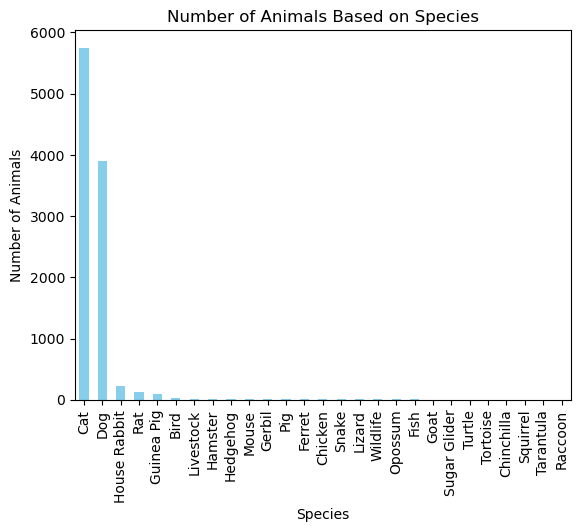

In [95]:
species_counts = data['speciesname'].value_counts()
species_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Animals Based on Species')
plt.xlabel('Species')
plt.ylabel('Number of Animals')

plt.show()

**Because cats and dogs are the most commonly occuring species in the shelter, we are going to focus on those two animals.**

In [96]:
selected_species = ['Cat', 'Dog']
new_data = data[data['speciesname'].isin(selected_species)]

def convert_age_to_months(age_str):
    age_list = age_str.split()
    years, months = 0, 0

    if 'years' in age_list:
        years = int(age_list[age_list.index('years') - 1])
    if 'months' in age_list:
        months = int(age_list[age_list.index('months') - 1])

    total_months = years * 12 + months
    return total_months

new_data = new_data.copy()
new_data.loc[:, 'age_in_months'] = new_data['animalage'].apply(convert_age_to_months)

new_data['adopted_binary'] = new_data['movementtype'].apply(lambda x: 1 if x == 'Adoption' else 0)

new_data.head()

,id,intakedate,intakereason,animalname,breedname,basecolour,speciesname,animalage,gender,location,movementdate,movementtype,returndate,returnedreason,deceaseddate,deceasedreason,age_in_months,adopted_binary
0,15801,"November 28, 2009",Moving,Jadzia,Domestic Short Hair,Tortie,Cat,9 years 2 months.,Female,Adoptable Cat Glass Colony,"May 13, 2017",Adoption,NaN,Stray,NaN,Died in care,108,1
1,15932,"December 08, 2009",Moving,Gonzo,German Shepherd Dog/Mix,Tan,Dog,9 years 1 month.,Male,Adoptable Dogs,"April 24, 2017",Adoption,NaN,Stray,NaN,Died in care,108,1
2,28859,"August 10, 2012",Abandoned,Maggie,Shep Mix/Siberian Husky,Various,Dog,6 years 8 months.,Female,Adoptable Dogs,"April 15, 2017",Adoption,NaN,Stray,NaN,Died in care,72,1
3,30812,"January 11, 2013",Abandoned,Pretty Girl,Domestic Short Hair,Dilute tortoiseshell,Cat,8 years 11 months.,Female,Stray Cats,"April 18, 2017",Foster,"May 29, 2018",Stray,NaN,Died in care,96,0
4,30812,"January 11, 2013",Abandoned,Pretty Girl,Domestic Short Hair,Dilute tortoiseshell,Cat,8 years 11 months.,Female,Stray Cats,"May 29, 2018",Adoption,NaN,Stray,NaN,Died in care,96,1


## Split into test and train data:

In [100]:
selected_columns = ['speciesname', 'age_in_months', 'basecolour', 'gender', 'adopted_binary']

model_data = new_data[selected_columns]

# Binary encoding for 'gender'
model_data['gender'] = model_data['gender'].apply(lambda x: 1 if x == 'Female' else 0)

# One-hot encoding for 'basecolour'
model_data = pd.get_dummies(model_data, columns=['basecolour'], drop_first=True)

# 1 for Cat, 0 for Dog
model_data['species_cat'] = model_data['speciesname'].apply(lambda x: 1 if x == 'Cat' else 0)

X = model_data.drop(['speciesname', 'species_cat'], axis=1)
y = model_data['species_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8259067357512954
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.65      0.75       782
           1       0.80      0.95      0.87      1148

    accuracy                           0.83      1930
   macro avg       0.84      0.80      0.81      1930
weighted avg       0.84      0.83      0.82      1930



/var/folders/35/gptj7yqx5wz56j492lzt6qj00000gn/T/ipykernel_15286/2931944513.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['gender'] = model_data['gender'].apply(lambda x: 1 if x == 'Female' else 0)
